In [1]:
from pandas.plotting import scatter_matrix
from time import time
from IPython.display import display 
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

data = pd.read_csv('online_shoppers_intention.csv')

In [2]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
data.shape

(12330, 18)

# Up Sampling The Dataset

In [4]:
def up_sample_minority_class():
    # Entries of the both minority and majority classes
    data_majority = data.loc[data['Revenue'] == 0.0]
    data_minority = data.loc[data['Revenue'] == 1.0]
    
    print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    #populates the minority portion of the samples up to the size of majority portion
    data_minority_up_sampled = resample(data_minority, 
                                     replace=True,
                                     n_samples=len(data_majority),
                                     random_state=142)
    
    # Combine majority class with upsampled minority class
    data_up_sampled = pd.concat([data_majority, data_minority_up_sampled])
    
    # Display new class counts
    print(data_up_sampled.Revenue.value_counts())
    
    X_up_sampled = np.array(data_up_sampled.drop(['Revenue'], 1).astype(float))
    y_up_sampled = np.array(data_up_sampled['Revenue']).astype(float)
    X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled = train_test_split(X_up_sampled, y_up_sampled, random_state=11)
    
    return X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled

In [5]:
def shrink_dataset(data, ratio):
    values_set = set(data.Revenue)
    
    data_shrinked = data
    data_shrinked = data_shrinked[0:0]
    
    for v in values_set:
        cr_class_entries = data_majority = data.loc[data['Revenue'] == v]

        original_length = len(cr_class_entries)
        cr_class_entries_shrinked = resample(cr_class_entries, 
                                         replace=True,
                                         n_samples=int(len(cr_class_entries)*ratio),
                                         random_state=142)
        
        print("cr_class_entries > {0} >>> {1} @ cr_class_entries_shrinked: {2}".format(v, original_length, len(cr_class_entries_shrinked)))

        # Combine majority class with upsampled minority class
        data_shrinked = pd.concat([data_shrinked, cr_class_entries_shrinked])
    
    # Display new class counts
    print(data_shrinked.Revenue.value_counts())
    
    return data_shrinked

#data = shrink_dataset(data, 0.1)

In [6]:
data.shape

(12330, 18)

In [7]:
data.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [8]:


ohe = OneHotEncoder(sparse=False)

data['Month'] =  ohe.fit_transform(data[['Month']])
data['VisitorType'] =  ohe.fit_transform(data[['VisitorType']])

scaler = MinMaxScaler()

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)


X = np.array(data.drop(['Revenue'], 1).astype(float))
y = np.array(data['Revenue']).astype(float)


time0 = time()


X_train, X_test, y_train, y_test = up_sample_minority_class()


clf = RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(X_train, y_train)



predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=0.5)))



time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))

data_majority: 10422 @ data_minority: 1908
1.0    10422
0.0    10422
Name: Revenue, dtype: int64

Accuracy Score: 0.9650738821723278
Precision Score: 0.9423144565599718
Recall Score: 0.9933259176863182
F-Beta Score: 0.9520932546733953

time elapsed: 0.3673708438873291



## Grid Search with All Features

In [4]:
# Import the necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

start_time = time()

print("Step 1\n------")
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42, n_jobs=-1)

# Create the parameters list 
parameters =  {
 'max_depth': [10,20,30,40],
 'max_features': [2, 3],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [8, 10, 12],
 'n_estimators': [50,100,150]}



# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

print("Step 2\n------")

# Perform grid search on the classifier 
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)


print("Step 3\n------")

# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train, y_train)


print("Step 4\n------")

# Get the estimator
best_clf = grid_fit.best_estimator_


print("Step 5\n------")

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


print("Step 6\n------")

end_time = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Total Time Elapsed: {0} seconds\n------".format((end_time-start_time)))
print("Accuracy score on testing data {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\ngrid_fit.best_params_: {0}".format(grid_fit.best_params_))

NameError: name 'time' is not defined

# Feature Selection via Boruta

In [11]:
from boruta import BorutaPy 

# define Boruta feature selection method
feat_selector = BorutaPy(clf, n_estimators='auto', verbose=2, alpha=0.20)
 
# find all relevant features
feat_selector.fit(X, y)
 
# check selected features
feat_selector.support_
 
# check ranking of features
feat_selector.ranking_

print("feat_selector.ranking_: {}".format(feat_selector.ranking_))



X = np.array(data.drop(['Revenue'], 1).astype(float))
y = np.array(data['Revenue']).astype(float)


X = feat_selector.transform(X)


time0 = time()


X_train, X_test, y_train, y_test = up_sample_minority_class()


clf = RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(X_train, y_train)


predictions = clf.predict(X_test)

print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=0.5)))



time1 = time()
diff = time1-time0
print("\ntime elapsed: {0}\n".format(diff))


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	6 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	7 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	11
feat_selector.ranking_: [ 2  1  6  4  1  1  1  1  1 11 12  8  7  5  3  9 10]
data_majority: 10422 @ data_minority: 1908
1.0    10422
0.0    10422
Name: Revenue, dtype: int64

Accuracy Score: 0.9644981769334101
Precision Score: 0.9397759103641457
Recall Score: 0.9951798294401186
F-Beta Score: 0.9503576233977763

time elapsed: 0.3901536464691162



## Gridsearch with Best Features

In [12]:
# Import the necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

start_time = time()

print("Step 1\n------")
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42, n_jobs=-1)


# Create the parameters list 
parameters =  {
    'max_depth': [15,20,25],
    'max_features': [3, 4],
    'min_samples_leaf': [4],
    'min_samples_split': [11, 12, 13],
    'n_estimators': [25,50,75]}



# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

print("Step 2\n------")

# Perform grid search on the classifier 
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)


print("Step 3\n------")

# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train, y_train)


print("Step 4\n------")

# Get the estimator
best_clf = grid_fit.best_estimator_


print("Step 5\n------")

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


print("Step 6\n------")

end_time = time()

# Report the before-and-afterscores
print("Optimized model With Best Features\n------")
print("Total Time Elapsed: {0} seconds\n------".format((end_time-start_time)))
print("Accuracy score on testing data {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\ngrid_fit.best_params_: {0}".format(grid_fit.best_params_))

Step 1
------
Step 2
------
Step 3
------
Step 4
------
Step 5
------
Step 6
------
Optimized model With Best Features
------
Total Time Elapsed: 97.52665114402771 seconds
------
Accuracy score on testing data 0.9639
F-score on testing data: 0.9507

Optimized Model
------
Final accuracy score on the testing data: 0.9294
Final F-score on the testing data: 0.9228

grid_fit.best_params_: {'max_depth': 25, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 75}


In [6]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [7]:
ohe = OneHotEncoder(sparse=False)

data['Month'] =  ohe.fit_transform(data[['Month']])
data['VisitorType'] =  ohe.fit_transform(data[['VisitorType']])

scaler = MinMaxScaler()

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

X = np.array(data.drop(['Revenue'], 1).astype(float))
y = np.array(data['Revenue']).astype(float)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)


data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,0.001418,0.000000,1.00,1.00,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.002837,0.001000,0.00,0.50,0.0,0.0,0.0,0.142857,0.083333,0.000,0.052632,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.001418,0.000000,1.00,1.00,0.0,0.0,0.0,0.428571,0.000000,1.000,0.105263,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.002837,0.000042,0.25,0.70,0.0,0.0,0.0,0.285714,0.083333,0.125,0.157895,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.014184,0.009809,0.10,0.25,0.0,0.0,0.0,0.285714,0.166667,0.000,0.157895,0.0,1.0,0.0


# Training And Eveluation PipeLine

In [8]:
from sklearn.metrics import accuracy_score, fbeta_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data 
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start 
    
    # Get the predictions on the test set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute accuracy on the first 300 training samples 
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    # Return the results
    return results

In [9]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Initialize the three models
random_state = 55

clf_A = RandomForestClassifier(random_state=random_state)
clf_B = GaussianNB()
clf_C = SVC(random_state=random_state)
clf_D = DecisionTreeClassifier()
clf_E = KNeighborsClassifier(n_neighbors=4)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10,   samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
results

RandomForestClassifier trained on 92 samples.
RandomForestClassifier trained on 924 samples.
RandomForestClassifier trained on 9247 samples.
GaussianNB trained on 92 samples.
GaussianNB trained on 924 samples.
GaussianNB trained on 9247 samples.
SVC trained on 92 samples.
SVC trained on 924 samples.
SVC trained on 9247 samples.
DecisionTreeClassifier trained on 92 samples.
DecisionTreeClassifier trained on 924 samples.
DecisionTreeClassifier trained on 9247 samples.
KNeighborsClassifier trained on 92 samples.
KNeighborsClassifier trained on 924 samples.
KNeighborsClassifier trained on 9247 samples.


{'RandomForestClassifier': {0: {'train_time': 0.1080169677734375,
   'pred_time': 0.026578664779663086,
   'acc_train': 0.9333333333333333,
   'acc_test': 0.8874472915990917,
   'f_train': 0.8675799086757991,
   'f_test': 0.6567915036333147},
  1: {'train_time': 0.13169550895690918,
   'pred_time': 0.03311634063720703,
   'acc_train': 1.0,
   'acc_test': 0.8913396042815439,
   'f_train': 1.0,
   'f_test': 0.6720867208672088},
  2: {'train_time': 0.8086287975311279,
   'pred_time': 0.04942035675048828,
   'acc_train': 1.0,
   'acc_test': 0.8984755108660396,
   'f_train': 1.0,
   'f_test': 0.6999471737982039}},
 'GaussianNB': {0: {'train_time': 0.0005707740783691406,
   'pred_time': 0.0023827552795410156,
   'acc_train': 0.84,
   'acc_test': 0.8387933830684399,
   'f_train': 0.5598455598455597,
   'f_test': 0.4617752693689071},
  1: {'train_time': 0.0007288455963134766,
   'pred_time': 0.0006897449493408203,
   'acc_train': 0.7366666666666667,
   'acc_test': 0.761271488809601,
   'f_trai

In [10]:
results[clf_A.__class__.__name__][2]['f_test']

0.6999471737982039

In [11]:
clf = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)

print("Train Set Score: {0}".format(clf.score(X_train, y_train)))
print("Test Set Score: {0}".format(clf.score(X_test, y_test)))
print("Cross Validation Score: {0}".format(np.mean(cross_val_score(clf,X,y))))

data.head()

Train Set Score: 0.9045095706715691
Test Set Score: 0.8978267920856309
Cross Validation Score: 0.8896188158961882


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,0.001418,0.000000,1.00,1.00,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.002837,0.001000,0.00,0.50,0.0,0.0,0.0,0.142857,0.083333,0.000,0.052632,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.001418,0.000000,1.00,1.00,0.0,0.0,0.0,0.428571,0.000000,1.000,0.105263,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.002837,0.000042,0.25,0.70,0.0,0.0,0.0,0.285714,0.083333,0.125,0.157895,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.014184,0.009809,0.10,0.25,0.0,0.0,0.0,0.285714,0.166667,0.000,0.157895,0.0,1.0,0.0


### GridSearchCV model_selection

In [8]:
# Import the necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

start_time = time()

print("Step 1\n------")
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42)


# Create the parameters list 
parameters =  {
    'max_depth': [15,20,25],
    'max_features': [3, 4],
    'min_samples_leaf': [4],
    'min_samples_split': [11, 12, 13],
    'n_estimators': [25,50,75]}



# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

print("Step 2\n------")

# Perform grid search on the classifier 
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)


print("Step 3\n------")

# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train, y_train)


print("Step 4\n------")

# Get the estimator
best_clf = grid_fit.best_estimator_


print("Step 5\n------")

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


print("Step 6\n------")

end_time = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Total Time Elapsed: {0} seconds\n------".format((end_time-start_time)))
print("Accuracy score on testing data {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\ngrid_fit.best_params_: {0}".format(grid_fit.best_params_))

Step 1
------
Step 2
------
Step 3
------


KeyboardInterrupt: 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

clf = RandomForestClassifier(max_depth=20, max_features=3
                             , min_samples_leaf=4, min_samples_split=12, n_estimators=50).fit(X_train, y_train)

predictions = clf.predict(X_test)

print("Accuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=0.5)))

Accuracy Score: 0.8952319169639961
Precision Score: 0.7575757575757576
Recall Score: 0.5070993914807302
F-Beta Score: 0.6894649751792609


In [13]:
def get_confusion_matrix(clf, X_test, y_test):
    true_positive = 0
    true_negative = 0 
    false_positive = 0 
    false_negative = 0
    
    y_test_list = y_test.tolist()

    all_successful_samples = 0
    all_positive_predictions = 0
    true_positives = 0

    predicts = clf.predict(X_test)

    for i in range(0, len(predicts)):
        if y_test_list[i] == 1:
            if predicts[i] == 1:
                true_positive += 1
            else:
                false_negative += 1
        else:
            if predicts[i] == 1:
                false_positive += 1
            else:
                true_negative += 1
    
    return true_positive, true_negative, false_positive, false_negative

In [14]:
def get_performance_metrics(clf, X_test, y_test):
    true_positive, true_negative, false_positive, false_negative = get_confusion_matrix(clf, X_test, y_test)
    
    accuracy = 0
    precision = 0
    recall = 0
    
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    precision = (true_positive) / (true_positive + false_positive)
    recall = (true_positive) / (true_positive + false_negative)
    
    return accuracy, precision, recall

In [15]:
accuracy, precision, recall = get_performance_metrics(clf, X_test, y_test)
print("accuracy: {0}\nprecision: {1}\nrecall: {2}\n"
      .format(accuracy, precision, recall))

accuracy: 0.8952319169639961
precision: 0.7575757575757576
recall: 0.5070993914807302



In [16]:
data.Revenue.value_counts()

0.0    10422
1.0     1908
Name: Revenue, dtype: int64

In [17]:
data.tail()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12325,0.111111,0.042663,0.0,0.0,0.075177,0.027883,0.035714,0.145153,0.033839,0.0,0.0,0.428571,0.416667,0.00,0.000000,0.0,1.0,0.0
12326,0.000000,0.000000,0.0,0.0,0.007092,0.007280,0.000000,0.106667,0.000000,0.0,0.0,0.285714,0.083333,0.00,0.368421,0.0,1.0,0.0
12327,0.000000,0.000000,0.0,0.0,0.008511,0.002880,0.416667,0.433333,0.000000,0.0,0.0,0.285714,0.083333,0.00,0.631579,0.0,1.0,0.0
12328,0.148148,0.022067,0.0,0.0,0.021277,0.005408,0.000000,0.105263,0.000000,0.0,0.0,0.142857,0.083333,0.25,0.526316,0.0,0.0,0.0
12329,0.000000,0.000000,0.0,0.0,0.004255,0.000332,0.000000,0.333333,0.000000,0.0,0.0,0.285714,0.083333,0.00,0.052632,1.0,1.0,0.0


# Down Sampling Solution

In [18]:
def down_sample_minority_class():
    # Entries of the both minority and majority classes
    data_majority = data.loc[data['Revenue'] == 0.0]
    data_minority = data.loc[data['Revenue'] == 1.0]
    
    print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    #populates the majority portion of the samples down to the number of minority portion
    data_majority_down_sampled = resample(data_majority, 
                                     replace=True,
                                     n_samples=len(data_minority),
                                     random_state=142)
    
    # Combine minority class with downsampled majority class
    data_down_sampled = pd.concat([data_minority, data_majority_down_sampled])
    
    
    # Display new class distrubution
    print("After Down-sampling:\n{0}".format(data_down_sampled.Revenue.value_counts()))
    
    X_down_sampled = np.array(data_down_sampled.drop(['Revenue'], 1).astype(float))
    y_down_sampled = np.array(data_down_sampled['Revenue']).astype(float)
    X_train_down_sampled, X_test_down_sampled, y_train_down_sampled, y_test_down_sampled = train_test_split(X_down_sampled, y_down_sampled, random_state=11)
    
    return X_train_down_sampled, X_test_down_sampled, y_train_down_sampled, y_test_down_sampled

In [19]:
X_train_down_sampled, X_test_down_sampled, y_train_down_sampled, y_test_down_sampled = down_sample_minority_class()

data_majority: 10422 @ data_minority: 1908
After Down-sampling:
0.0    1908
1.0    1908
Name: Revenue, dtype: int64


In [20]:
clf_down_sampled = RandomForestClassifier(max_depth=20, max_features=3
                             , min_samples_leaf=4, min_samples_split=12, n_estimators=50).fit(X_train_down_sampled, y_train_down_sampled)

predictions_down_sampled = clf_down_sampled.predict(X_test_down_sampled)

print("Accuracy Score: {0}".format(accuracy_score(y_test_down_sampled, predictions_down_sampled)))
print("Precision Score: {0}".format(precision_score(y_test_down_sampled, predictions_down_sampled)))
print("Recall Score: {0}".format(recall_score(y_test_down_sampled, predictions_down_sampled)))
print("F-Beta Score: {0}".format(fbeta_score(y_test_down_sampled, predictions_down_sampled, beta=0.5)))

Accuracy Score: 0.8574423480083857
Precision Score: 0.8641425389755011
Recall Score: 0.838012958963283
F-Beta Score: 0.8587870739265161


In [21]:
accuracy, precision, recall = get_performance_metrics(clf_down_sampled, X_test_down_sampled, y_test_down_sampled)
print("accuracy: {0}\nprecision: {1}\nrecall: {2}\n"
      .format(accuracy, precision, recall))

accuracy: 0.8574423480083857
precision: 0.8641425389755011
recall: 0.838012958963283



# Up Sampling Solution

In [121]:
def up_sample_minority_class():
    # Entries of the both minority and majority classes
    data_majority = data.loc[data['Revenue'] == 0.0]
    data_minority = data.loc[data['Revenue'] == 1.0]
    
    print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    #populates the minority portion of the samples up to the size of majority portion
    data_minority_up_sampled = resample(data_minority, 
                                     replace=True,
                                     n_samples=len(data_majority),
                                     random_state=142)
    
    # Combine majority class with upsampled minority class
    data_up_sampled = pd.concat([data_majority, data_minority_up_sampled])
    
    # Display new class counts
    print(data_up_sampled.Revenue.value_counts())
    
    X_up_sampled = np.array(data_up_sampled.drop(['Revenue'], 1).astype(float))
    y_up_sampled = np.array(data_up_sampled['Revenue']).astype(float)
    X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled = train_test_split(X_up_sampled, y_up_sampled, random_state=11)
    
    return X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled

In [23]:
X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled = up_sample_minority_class()

data_majority: 10422 @ data_minority: 1908
1.0    10422
0.0    10422
Name: Revenue, dtype: int64


In [24]:
clf_up_sampled = RandomForestClassifier(max_depth=20, max_features=3
                             , min_samples_leaf=4, min_samples_split=12, n_estimators=50).fit(X_train_up_sampled, y_train_up_sampled)

predictions_up_sampled = clf_up_sampled.predict(X_test_up_sampled)

print("Accuracy Score: {0}".format(accuracy_score(y_test_up_sampled, predictions_up_sampled)))
print("Precision Score: {0}".format(precision_score(y_test_up_sampled, predictions_up_sampled)))
print("Recall Score: {0}".format(recall_score(y_test_up_sampled, predictions_up_sampled)))
print("F-Beta Score: {0}".format(fbeta_score(y_test_up_sampled, predictions_up_sampled, beta=0.5)))

Accuracy Score: 0.9261178276722318
Precision Score: 0.9149318018664753
Recall Score: 0.9451242120875046
F-Beta Score: 0.9208149700166173


In [25]:
accuracy, precision, recall = get_performance_metrics(clf_up_sampled, X_test_up_sampled, y_test_up_sampled)
print("accuracy: {0}\nprecision: {1}\nrecall: {2}\n"
      .format(accuracy, precision, recall))

accuracy: 0.9261178276722318
precision: 0.9149318018664753
recall: 0.9451242120875046



### GridSearchCV model_selection

In [116]:
# Import the necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

start_time = time()

print("Step 1\n------")
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42)

#     ...
#     # Create the parameters list 
#     parameters =  {
#         'max_depth': [10,20,30,40],
#         'max_features': [2, 3],
#         'min_samples_leaf': [3, 4, 5],
#         'min_samples_split': [8, 10, 12],
#         'n_estimators': [50,100,150]}
#     ...

# Create the parameters list 
parameters =  {
    'max_depth': [5,10,20,30,40],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5, 7, 9],
    'min_samples_split': [8, 10, 12, 20, 50],
    'n_estimators': [50,100,150]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

print("Step 2\n------")

# Perform grid search on the classifier 
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)


print("Step 3\n------")

# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train_down_sampled, y_train_down_sampled)


print("Step 4\n------")

# Get the estimator
best_clf = grid_fit.best_estimator_


print("Step 5\n------")

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train_down_sampled, y_train_down_sampled)).predict(X_test_down_sampled)
best_predictions = best_clf.predict(X_test_down_sampled)


print("Step 6\n------")

end_time = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Total Time Elapsed: {0} seconds\n------".format((end_time-start_time)))
print("Accuracy score on testing data {:.4f}".format(accuracy_score(y_test_down_sampled, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test_down_sampled, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_down_sampled, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_down_sampled, best_predictions, beta = 0.5)))
print("\ngrid_fit.best_params_: {0}".format(grid_fit.best_params_))


Step 1
------
Step 2
------
Step 3
------
Step 4
------
Step 5
------
Step 6
------
Unoptimized model
------
Total Time Elapsed: 1690.7716391086578 seconds
------
Accuracy score on testing data 0.9011
F-score on testing data: 0.6551

Optimized Model
------


ValueError: Found input variables with inconsistent numbers of samples: [3083, 954]

In [119]:

print("Step 5\n------")

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train_down_sampled, y_train_down_sampled)).predict(X_test_down_sampled)
best_predictions = best_clf.predict(X_test_down_sampled)


print("Step 6\n------")

end_time = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Total Time Elapsed: {0} seconds\n------".format((end_time-start_time)))
print("Accuracy score on testing data {:.4f}".format(accuracy_score(y_test_down_sampled, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test_down_sampled, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_down_sampled, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_down_sampled, best_predictions, beta = 0.5)))
print("\ngrid_fit.best_params_: {0}".format(grid_fit.best_params_))


Step 5
------
Step 6
------
Unoptimized model
------
Total Time Elapsed: 2332.347555398941 seconds
------
Accuracy score on testing data 0.8574
F-score on testing data: 0.8619

Optimized Model
------
Final accuracy score on the testing data: 0.8512
Final F-score on the testing data: 0.8544

grid_fit.best_params_: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 150}


In [120]:
clf_best_down_sampled = RandomForestClassifier(max_depth=20, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=150, random_state = 42).fit(X_train_down_sampled, y_train_down_sampled)

print("Train Set Score: {0}".format(clf_up_sampled.score(X_train_up_sampled, y_train_up_sampled)))
print("Test Set Score: {0}".format(clf_up_sampled.score(X_test_up_sampled, y_test_up_sampled)))
print("Cross Validation Score: {0}".format(np.mean(cross_val_score(clf_up_sampled,X,y))))

Train Set Score: 0.9568860743299431
Test Set Score: 0.9238150067165611
Cross Validation Score: 0.8939983779399837


In [123]:
# Import the necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

start_time = time()

print("Step 1\n------")
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42)

#     ...
#     # Create the parameters list 
#     parameters =  {
#         'max_depth': [10,20,30,40],
#         'max_features': [2, 3],
#         'min_samples_leaf': [3, 4, 5],
#         'min_samples_split': [8, 10, 12],
#         'n_estimators': [50,100,150]}
#     ...

# Create the parameters list 
parameters =  {
    'max_depth': [5,10,20,30,40],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5, 7, 9],
    'min_samples_split': [8, 10, 12, 20, 50],
    'n_estimators': [50,100,150]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

print("Step 2\n------")

# Perform grid search on the classifier 
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)


print("Step 3\n------")

# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train_up_sampled, y_train_up_sampled)


print("Step 4\n------")

# Get the estimator
best_clf = grid_fit.best_estimator_


print("Step 5\n------")

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train_up_sampled, y_train_up_sampled)).predict(X_test_up_sampled)
best_predictions = best_clf.predict(X_test_up_sampled)


print("Step 6\n------")

end_time = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Total Time Elapsed: {0} seconds\n------".format((end_time-start_time)))
print("Accuracy score on testing data {:.4f}".format(accuracy_score(y_test_up_sampled, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test_up_sampled, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_up_sampled, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_up_sampled, best_predictions, beta = 0.5)))
print("\ngrid_fit.best_params_: {0}".format(grid_fit.best_params_))



Step 1
------
Step 2
------
Step 3
------
Step 4
------
Step 5
------
Step 6
------
Unoptimized model
------
Total Time Elapsed: 6548.905949831009 seconds
------
Accuracy score on testing data 0.9601
F-score on testing data: 0.9399

Optimized Model
------
Final accuracy score on the testing data: 0.9369
Final F-score on the testing data: 0.9185

grid_fit.best_params_: {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 150}


In [121]:
accuracy, precision, recall = get_performance_metrics(clf_down_sampled, X_test_down_sampled, y_test_down_sampled)
print("accuracy: {0}\nprecision: {1}\nrecall: {2}\n"
      .format(accuracy, precision, recall))

accuracy: 0.8522012578616353
precision: 0.8616071428571429
recall: 0.8301075268817204



In [124]:
accuracy, precision, recall = get_performance_metrics(clf_up_sampled, X_test_up_sampled, y_test_up_sampled)
print("accuracy: {0}\nprecision: {1}\nrecall: {2}\n"
      .format(accuracy, precision, recall))

accuracy: 0.9238150067165611
precision: 0.8983859134262656
recall: 0.9532892175943947



## Plotting Random Forest Classifier performances with normal, up-sampled and down-sampled data

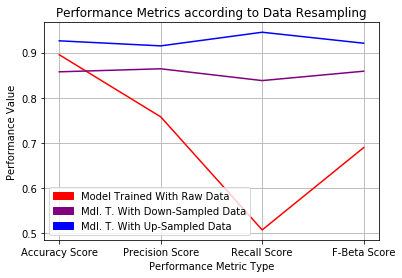

In [26]:
import matplotlib.patches as mpatches

x_labels = ['Accuracy Score', 'Precision Score', 'Recall Score', 'F-Beta Score (β=0.50)']

y_units_raw_data = [accuracy_score(y_test, predictions),
                   precision_score(y_test, predictions),
                   recall_score(y_test, predictions),
                   fbeta_score(y_test, predictions, beta=0.5)]

y_units_down_sampled = [accuracy_score(y_test_down_sampled, predictions_down_sampled),
                       precision_score(y_test_down_sampled, predictions_down_sampled),
                       recall_score(y_test_down_sampled, predictions_down_sampled),
                       fbeta_score(y_test_down_sampled, predictions_down_sampled, beta=0.5)]

y_units_up_sampled = [accuracy_score(y_test_up_sampled, predictions_up_sampled), 
                   precision_score(y_test_up_sampled, predictions_up_sampled),
                   recall_score(y_test_up_sampled, predictions_up_sampled),
                   fbeta_score(y_test_up_sampled, predictions_up_sampled, beta=0.5)]


plt.title('Performance Metrics according to Data Resampling')
plt.xlabel('Performance Metric Type')
plt.ylabel('Performance Value')

plt.plot(y_units_raw_data, color='red')
plt.plot(y_units_down_sampled, color='purple')
plt.plot(y_units_up_sampled, color='blue')

raw_data_patch = mpatches.Patch(color='red', label='Model Trained With Raw Data')
down_sampled_patch = mpatches.Patch(color='purple', label='Mdl. T. With Down-Sampled Data')
up_sampled_patch = mpatches.Patch(color='blue', label='Mdl. T. With Up-Sampled Data')
plt.legend(handles=[raw_data_patch, down_sampled_patch, up_sampled_patch])

x_labels = ['Accuracy Score', 'Precision Score', 'Recall Score', 'F-Beta Score']

#plt.xticks(range(0, len(x_labels)), x_labels.index)
plt.xticks(np.arange(len(x_labels)), x_labels)

plt.grid(True)

plt.show()
